In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import imageio

In [2]:
torch.manual_seed(1)    # reproducible

mu, lambd = -0.3, -0.6
min_x = [-1., -1.]
max_x = [1., 1.]
dt=1e-2
n_pts = 500
x = torch.Tensor(np.random.uniform(min_x, max_x, (n_pts,2)))  # x data (tensor), shape=(100, 1)
y = dt*torch.cat((mu*x[:,0].reshape(-1,1), (-lambd*x[:,0].pow(2) + lambd*x[:,1]).reshape(-1,1)), 1)# + dt*0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)
X = torch.cat((x, x+y),1)

# torch can only train on Variable, so convert them to Variable
X, y = Variable(X), Variable(y)

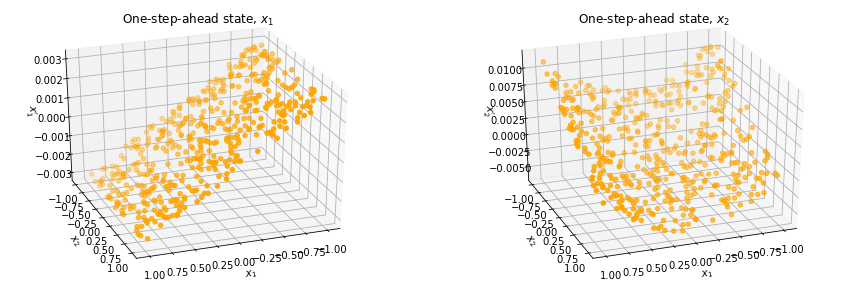

In [3]:
# view data
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(x[:,0].data.numpy(), x[:,1].data.numpy(), y[:,0].data.numpy(), color = "orange")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel("$x_1'$")
ax.set_title('One-step-ahead state, $x_1$')
ax.view_init(30, 70)

ax = fig.add_subplot(122, projection='3d')
ax.scatter(x[:,0].data.numpy(), x[:,1].data.numpy(), y[:,1].data.numpy(), color = "orange")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel("$x_2'$")
ax.set_title('One-step-ahead state, $x_2$')
ax.view_init(30, 70)

plt.show()

In [7]:
class Net(torch.nn.Module):
    def __init__(self, n, n_feature, n_layers, n_hidden, n_output):
        super(Net, self).__init__()        
        self.loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
        self.optimization_parameters = []
        
        self.hidden_lyrs = [torch.nn.Linear(n, n_hidden)]
        for _ in range(1, n_layers):
            self.hidden_lyrs.append(torch.nn.Linear(n_hidden, n_hidden))
        self.predict = torch.nn.Linear(n_hidden, n_feature)
        self.predict_norm = torch.nn.BatchNorm1d(n_feature)
        
        self.koopman_fc = torch.nn.Linear(n+n_feature,n+n_feature, bias=False)
        
        # Set optimization variables:
        for layer in self.hidden_lyrs:
            self.optimization_parameters.append(layer.weight)
            self.optimization_parameters.append(layer.bias)
        
        self.optimization_parameters.append(self.predict.weight)
        self.optimization_parameters.append(self.predict.bias)
        self.optimization_parameters.append(self.koopman_fc.weight)

    def forward(self, X):
        x = X[:,:2]
        x_prime = X[:, 2:]
        
        phi = F.relu(self.hidden_lyrs[0](x))
        for ii in range(1, len(self.hidden_lyrs)):
            phi = F.relu(self.hidden_lyrs[ii](phi))
        phi = self.predict(phi)
        phi = self.predict_norm(phi)
        
        z = torch.cat((x, phi), 1)
        z_prime_pred = self.koopman_fc(z)             # linear output
        
        
        phi_prime = F.relu(self.hidden_lyrs[0](x_prime))
        for ii in range(1, len(self.hidden_lyrs)):
            phi_prime = F.relu(self.hidden_lyrs[ii](phi_prime))
        phi_prime = self.predict(phi_prime)
        phi_prime = self.predict_norm(phi_prime)
        
        z_prime = torch.cat((x_prime, phi_prime), 1) - z
        
        return torch.cat((z_prime_pred, z_prime),1)
    
    def koop_loss(self, prediction, target):
        z_prime_pred = prediction[:, :3]
        z_prime = prediction[:, 3:]
        x_prime_pred = z_prime_pred[:, :2]
        
        loss = self.loss_func(x_prime_pred, target/dt)     # must be (1. nn output, 2. target)
        loss_reg = self.loss_func(z_prime_pred[:,2:], z_prime[:,2:]/dt)
        
        tot_loss = loss + loss_reg + 1e-2*torch.norm(self.koopman_fc.weight, 1)
        return tot_loss

net = Net(n=2, n_feature=1, n_layers=1, n_hidden=100, n_output=1)     # define the network
optimizer = torch.optim.Adam(net.optimization_parameters, lr=1e-1)


Epoch:  0 , loss:  0.62795603
Epoch:  25 , loss:  0.051692735
Epoch:  50 , loss:  0.04129102
Epoch:  75 , loss:  0.03632911
Epoch:  100 , loss:  0.033765852
Epoch:  125 , loss:  0.033056628
Epoch:  150 , loss:  0.032859642
Epoch:  175 , loss:  0.032800253
Epoch:  200 , loss:  0.032843888
Epoch:  225 , loss:  0.032806687
Epoch:  250 , loss:  0.032697223
Epoch:  275 , loss:  0.03277946
Epoch:  300 , loss:  0.032876387
Epoch:  325 , loss:  0.03282042
Epoch:  350 , loss:  0.032621693
Epoch:  375 , loss:  0.032748114
Epoch:  400 , loss:  0.032437764
Epoch:  425 , loss:  0.032595273
Epoch:  450 , loss:  0.03294014
Epoch:  475 , loss:  0.032657564
Epoch:  500 , loss:  0.032418415
Epoch:  525 , loss:  0.03242023
Epoch:  550 , loss:  0.032471724
Epoch:  575 , loss:  0.032411963
Epoch:  600 , loss:  0.0323824
Epoch:  625 , loss:  0.03244032
Epoch:  650 , loss:  0.032516632
Epoch:  675 , loss:  0.032386996
Epoch:  700 , loss:  0.032361984
Epoch:  725 , loss:  0.03242394
Epoch:  750 , loss:  0.032

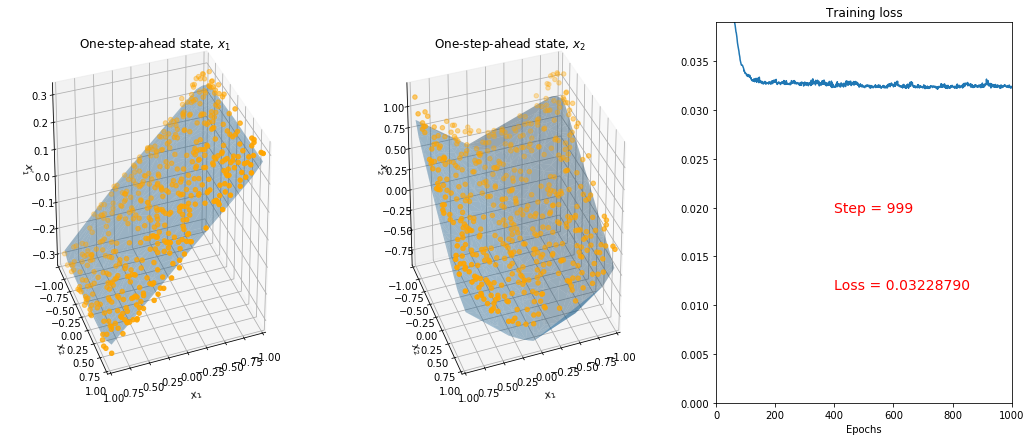

In [8]:
my_images = []
fig = plt.figure(figsize=(18,7))
ax = [fig.add_subplot(131, projection='3d'), fig.add_subplot(132, projection='3d'), fig.add_subplot(133)]
loss_hist = []

# train the network
n_epochs = 1000
for t in range(n_epochs):
  
    prediction = net(X)     # input x and predict based on x

    loss = net.koop_loss(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    loss_hist.append(loss.data.numpy())
    
    # plot and show learning process
    for ii in range(2):
        ax[ii].cla()
        ax[ii].set_xlim(-1, 1)
        ax[ii].set_ylim(-1, 1)
        #ax[ii].set_zlim(-0.02, 0.02)
        ax[ii].scatter(x[:,0].data.numpy(), x[:,1].data.numpy(), y[:,ii].data.numpy()/dt, color = "orange")
        ax[ii].plot_trisurf(x[:,0].data.numpy(), x[:,1].data.numpy(), prediction[:,ii].data.numpy(), alpha=0.4, shade=True)
        ax[ii].set_xlabel('$x_1$')
        ax[ii].set_ylabel('$x_2$')
        ax[ii].set_zlabel('$x_' + str(ii+1) + "'$")
        ax[ii].set_title('One-step-ahead state, $x_' + str(ii+1) + '$')
        ax[ii].view_init(30, 70)

    hist_index = max(0, t - 100)
    plot_max = 1.2*np.mean(loss_hist[hist_index:])
    ax[-1].cla()
    ax[-1].plot(range(len(loss_hist)), loss_hist)
    ax[-1].set_xlim(0, n_epochs)
    ax[-1].set_ylim(0, plot_max)
    ax[-1].set_title('Training loss')
    ax[-1].set_xlabel('Epochs')
    ax[-1].text(int(0.4*n_epochs), 0.5*plot_max, 'Step = %d' % t, fontdict={'size': 14, 'color':  'red'})
    ax[-1].text(int(0.4*n_epochs), 0.3*plot_max, 'Loss = %.8f' % loss_hist[-1],
                fontdict={'size': 14, 'color':  'red'})

    # Used to return the plot as an image array 
    # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    my_images.append(image)
    if t%25 == 0:
        print('Epoch: ', t, ', loss: ', loss.data.numpy())
    
# save images as a gif    
imageio.mimsave('figures/koop_simplified.gif', my_images, fps=10)

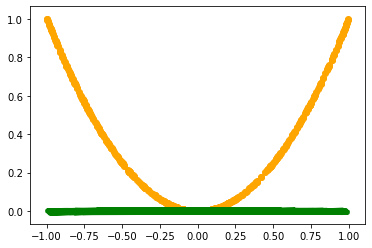

[[-0.27036002  0.00299194 -0.00474554]
 [-0.00246875 -0.3038184   0.2398312 ]
 [-0.00563535 -0.00422288 -0.00163377]]


In [15]:
# Check if learned lifting function is x^2:
y_sq = x[:,0].pow(2)
plt.figure()
plt.scatter(x[:,0].data.numpy(), y_sq.data.numpy(), color = "orange")
plt.plot(x[:,0].data.numpy(), prediction[:,2].data.numpy(), 'g-', lw=3)
plt.show()

print(net.koopman_fc.weight.data.numpy())

(500,)
(500, 3) (500, 3)


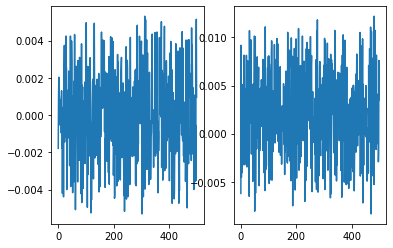

1.4917957e-05


In [28]:
A = net.koopman_fc.weight.data.numpy()*dt
x_test = torch.Tensor(np.random.uniform(min_x, max_x, (n_pts,2)))  # x data (tensor), shape=(100, 1)
y_test = dt*np.concatenate((mu*x[:,0].reshape(-1,1), (-lambd*x[:,0].pow(2) + lambd*x[:,1]).reshape(-1,1)), 1)
phi_test = net(torch.cat((x_test, torch.zeros_like(x_test)), 1)).data.numpy()[:, 2]
print(phi_test.shape)
z_test = np.concatenate((x_test, phi_test.reshape(-1,1)), axis=1)
z_pred_test = (z_test@A.T)

print(z_test.shape, z_pred_test.shape)

plt.figure()
plt.subplot(1,2,1)
plt.plot(y_test[:,0] - z_pred_test[:,0])

plt.subplot(1,2,2)
plt.plot(y_test[:,1] - z_pred_test[:,1])

plt.show()

print(np.mean(np.square(z_pred_test[:, :2] - y_test[:, :2])))